In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from plotnine import *
from pathlib import Path
from tqdm import tqdm
import seaborn as sns
import numpy as np
from datetime import datetime
from enhance_ocod.analysis import create_summarised_stats, create_mean_difference_by_groups

data_folder = Path('../data') 
figures_folder = Path('../figures/figures_any_non_match')
figures_folder.mkdir(parents=True, exist_ok=True)

OCOD_history_path = data_folder / 'ocod_history_processed_any_non_match' 

list_of_files = list(OCOD_history_path.iterdir())

active_class_var = 'class'


LAD_COLUMN_CODE = 'LAD22CD' # change this according to the shapefile you are using
LAD_COLUMN_NAME = "LAD22NM"

In [3]:
target_file = OCOD_history_path /'OCOD_FULL_2022_02.parquet'

reference_year = pd.read_parquet(target_file)

In [4]:
postcode_test = reference_year.loc[ reference_year[active_class_var].isin(['residential'])].copy()
postcode_test['has_postcode'] = postcode_test['postcode'].notna()

In [5]:
postcode_test.groupby('has_postcode').size()/postcode_test.shape[0]

has_postcode
False    0.341642
True     0.658358
dtype: float64

In [6]:
total_residential_df, total_per_region_df, total_incorp_df, total_resi_lad_df = create_summarised_stats(list_of_files, active_class_var)

100%|██████████| 99/99 [00:38<00:00,  2.59it/s]


In [7]:
total_per_region_df.groupby(active_class_var)['counts'].sum()/total_per_region_df['counts'].sum()

class
airspace       0.009025
business       0.085104
carpark        0.015175
land           0.092416
residential    0.739524
unknown        0.058756
Name: counts, dtype: float64

/tmp/ipykernel_447644/2107818374.py:7: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../figures_any_non_match/total_properties.png


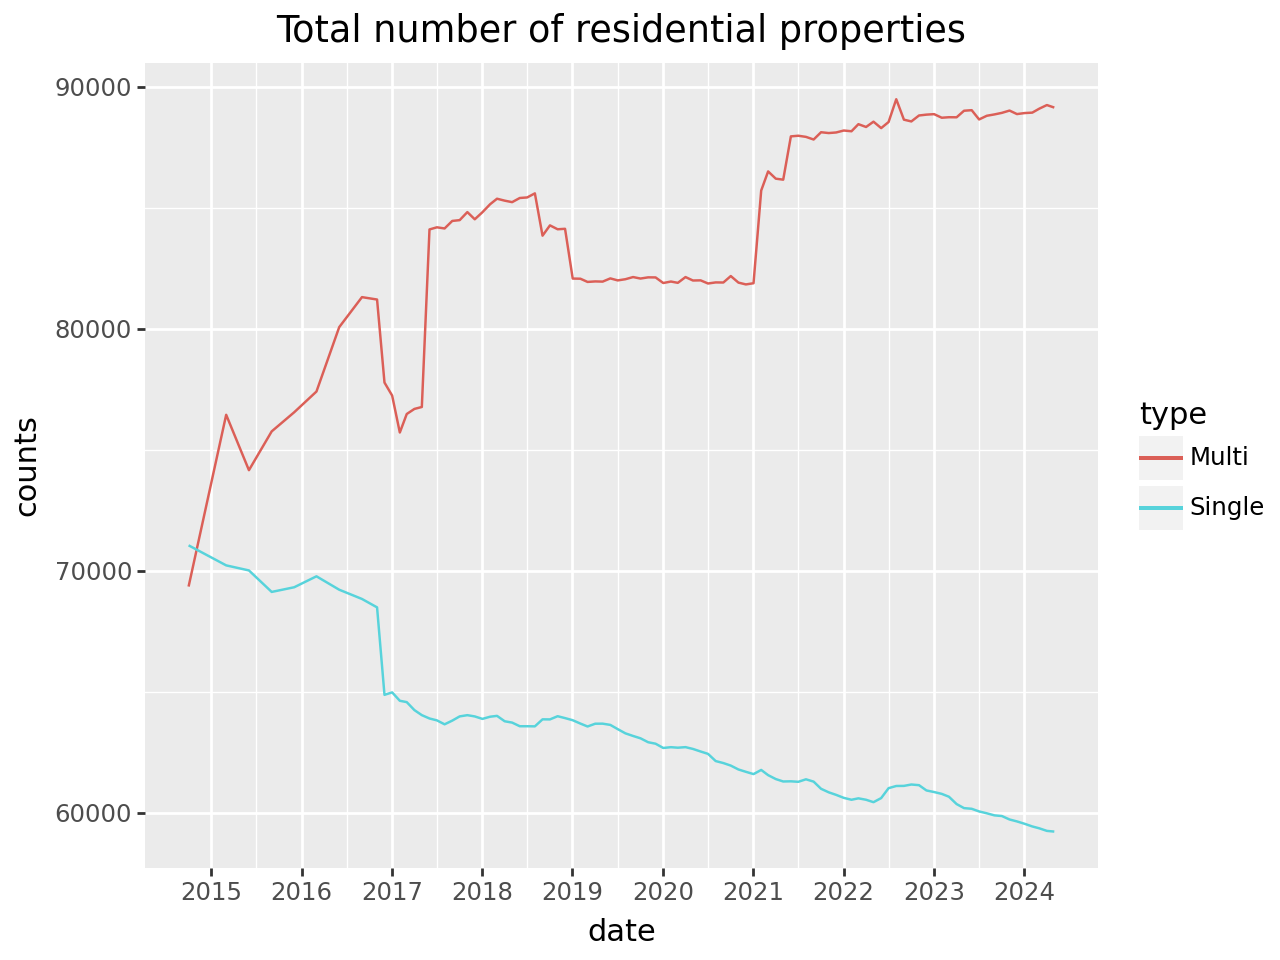

In [8]:

total_residential_df['type'] = np.where(total_residential_df['is_multi'], 'Multi', 'Single')

p = ggplot(total_residential_df, aes(x = 'date', 
y = 'counts', 
color = 'type') )+ geom_line() + labs(
    title = "Total number of residential properties") +   scale_x_date(
     breaks=pd.date_range(start=total_residential_df['date'].min(), end=total_residential_df['date'].max(), freq='Y'),
     date_labels='%Y'  # Format to show only year
 )

p.save(filename = figures_folder /'total_properties.png')

p

/tmp/ipykernel_447644/414228278.py:5: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../figures_any_non_match/properties_by_region.png


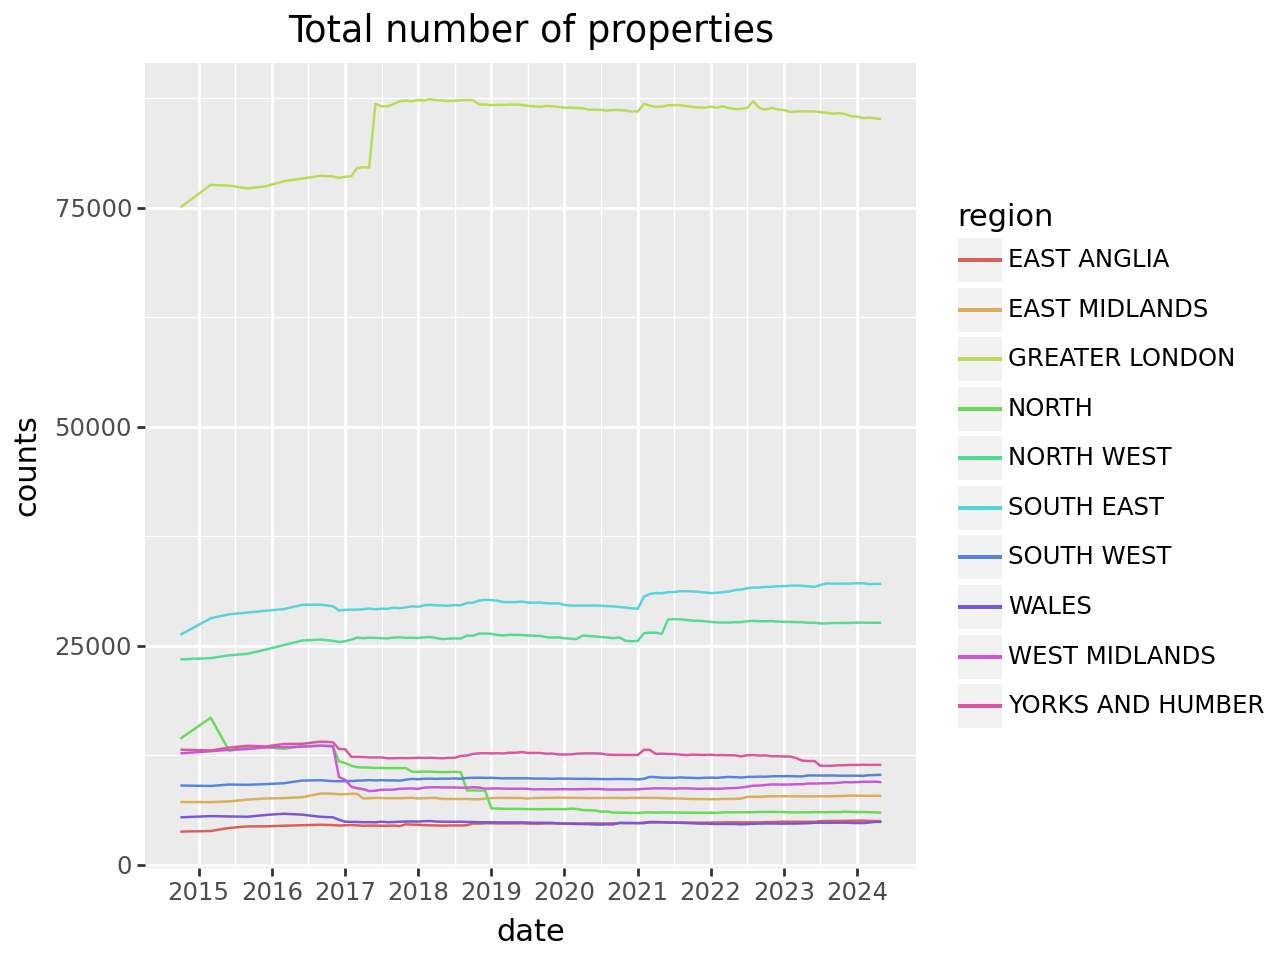

In [9]:

p = ggplot(total_per_region_df.groupby(['region', 'date'])['counts'].sum().reset_index(), aes(x='date', y='counts', color='region')) + \
    geom_line() + \
    labs(title="Total number of properties") + \
    scale_x_date(
        breaks=pd.date_range(start=total_residential_df['date'].min(), end=total_residential_df['date'].max(), freq='Y'),
        date_labels='%Y'
    ) 

p.save(filename = figures_folder /'properties_by_region.png')

p

/tmp/ipykernel_447644/1102713082.py:7: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../figures_any_non_match/properties_by_class.png


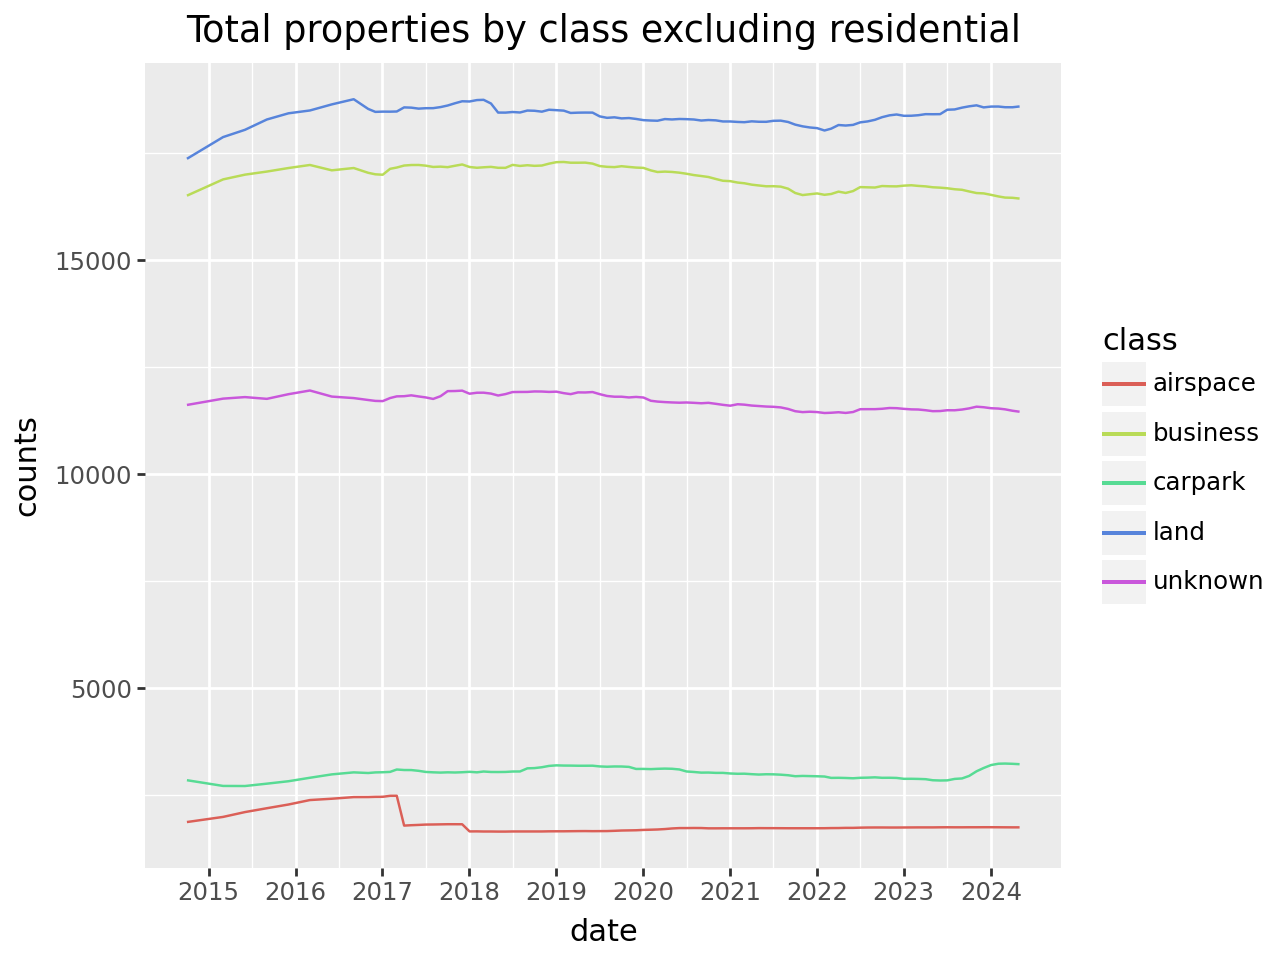

In [10]:
total_per_class_df = total_per_region_df.groupby([active_class_var, 'date'])['counts'].sum().reset_index()

p = ggplot(total_per_class_df.loc[total_per_class_df[active_class_var]!='residential'], aes(x = 'date', 
y = 'counts', 
color = active_class_var) )+ geom_line() + labs(
    title = "Total properties by class excluding residential") +   scale_x_date(
     breaks=pd.date_range(start=total_residential_df['date'].min(), end=total_residential_df['date'].max(), freq='Y'),
     date_labels='%Y'  # Format to show only year
 )

p.save(filename = figures_folder /'properties_by_class.png')

p

In [11]:
temp_class = total_per_class_df.pivot(index = 'date', columns = active_class_var, values = 'counts')

temp_class['res_perc'] = temp_class['residential']/temp_class.sum(axis = 1)
temp_class


class,airspace,business,carpark,land,residential,unknown,res_perc
date,,,,,,,
2015-10-01,1869,16509,2847,17371,140396,11617,0.736565
2016-03-01,1989,16889,2713,17878,146666,11765,0.741112
2016-06-01,2102,17000,2711,18048,144168,11801,0.736190
2016-09-01,2192,17072,2766,18289,144883,11760,0.735589
2016-12-01,2279,17155,2823,18434,145866,11869,0.735115
...,...,...,...,...,...,...,...
2025-01-01,1748,16528,3201,18591,148455,11541,0.742038
2025-02-01,1747,16491,3232,18592,148363,11533,0.741971
2025-03-01,1746,16464,3236,18576,148449,11515,0.742297


# Country of incorporation

In [12]:
total_incorp_df['country_incorporated'] = total_incorp_df['country_incorporated'].str.replace("BRITISH VIRGIN ISLANDS", "BVI")

country_totals = total_incorp_df.groupby('country_incorporated')['counts'].mean()

top_10_countries = country_totals.nlargest(20).index

# The top four dominate so massively there is no point in having anyone else
top_4_countries = country_totals.nlargest(4).index

filtered_df = total_incorp_df[total_incorp_df['country_incorporated'].isin(top_4_countries)]

print("Top 10 countries by total counts:")
print(country_totals.nlargest(20))

Top 10 countries by total counts:
country_incorporated
JERSEY              53114.545455
GUERNSEY            48651.020202
BVI                 32062.030303
ISLE OF MAN         18566.696970
GIBRALTAR            5731.383838
LUXEMBOURG           4986.393939
IRELAND              2688.646465
SINGAPORE            2356.474747
PANAMA               2079.717172
HONG KONG            2046.848485
NETHERLANDS          1943.262626
CAYMAN ISLANDS       1927.060606
SEYCHELLES           1874.060606
CYPRUS               1772.111111
MAURITIUS            1766.333333
AUSTRALIA            1644.616162
BAHAMAS              1636.080808
GERMANY              1314.050505
BERMUDA               824.727273
DELAWARE, U.S.A.      818.515152
Name: counts, dtype: float64


## Total Fraction the top four make up

In [13]:
total_incorp_df.loc[total_incorp_df['country_incorporated'].isin(['BVI', 'JERSEY', 'GUERNSEY', 'ISLO OF MAN']),'counts'].sum()/total_incorp_df['counts'].sum()

0.6726783061072131

/tmp/ipykernel_447644/1908593201.py:7: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../figures_any_non_match/properties_by_incorporation.png


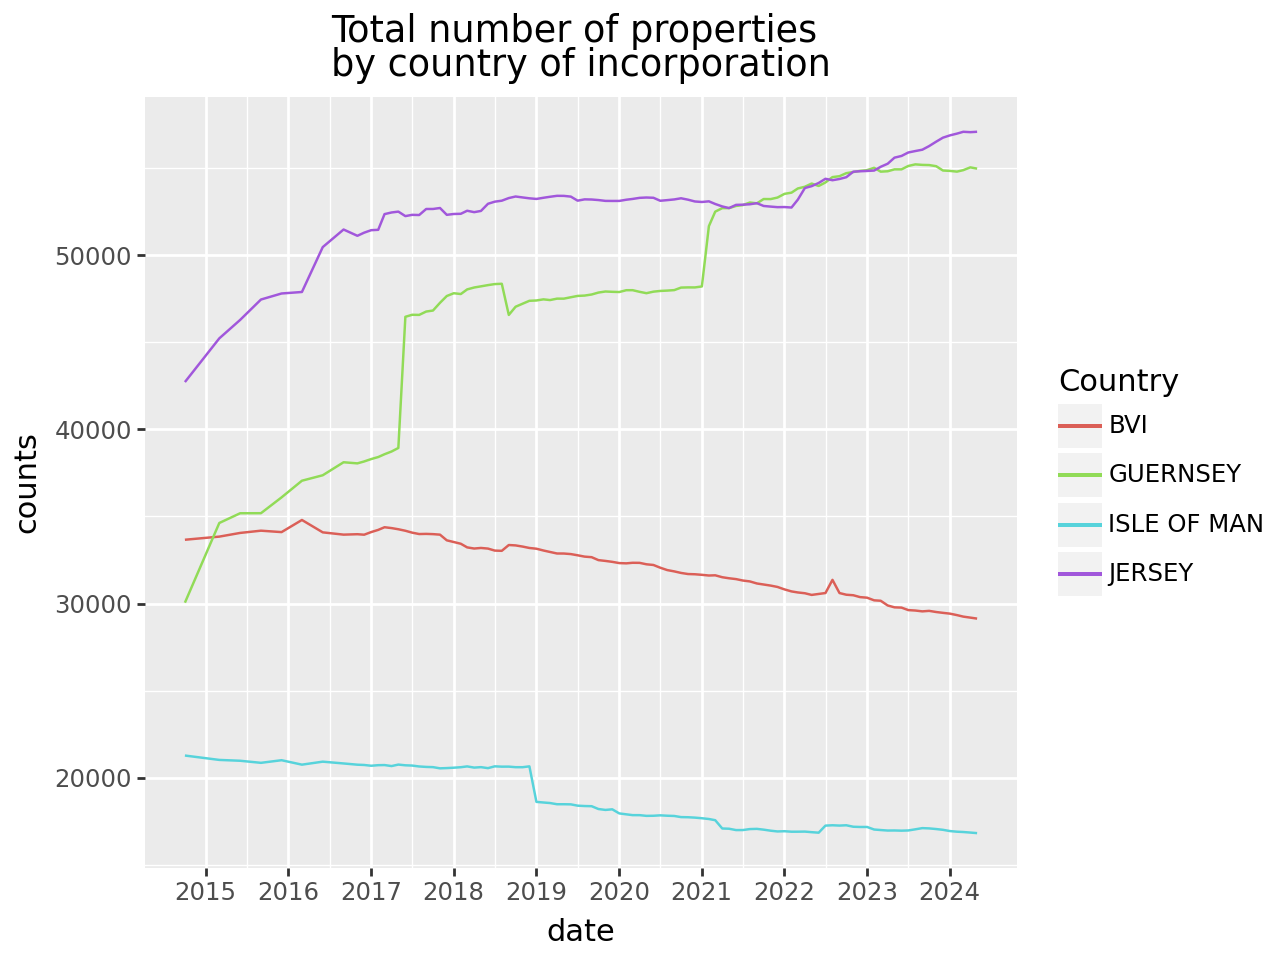

In [14]:
p = ggplot(filtered_df, aes(x = 'date', 
y = 'counts', 
color = 'country_incorporated') )+ geom_line() + labs(
    title = "Total number of properties\nby country of incorporation",
    color = 'Country'
    ) +   scale_x_date(
     breaks=pd.date_range(start=filtered_df['date'].min(), end=filtered_df['date'].max(), freq='Y'),
     date_labels='%Y'  # Format to show only year
 ) 

p.save(filename = figures_folder /'properties_by_incorporation.png')

p


In [15]:
test = total_incorp_df.copy()

test['diff'] = (test['counts'] - test.groupby('country_incorporated')['counts'].shift())/test.groupby('country_incorporated')['counts'].shift()

country_totals = test.groupby('country_incorporated')['diff'].mean()

# Step 2: Get the top 10 countries
top_10_countries = country_totals.nlargest(20).index

print(country_totals.nlargest(20))

country_incorporated
CHILE                       2.366656
MADEIRA                     1.652116
VERMONT, U.S.A.             1.366075
MAURITIUS                   1.165930
ABU DHABI                   1.161999
FUJAIRAH                    1.127463
PAMANA                      1.000000
JORDAN                      0.568381
COLORADO, U.S.A.            0.544523
SWEDEN                      0.523879
THE VIRGIN ISLANDS          0.520902
AUSTRALIA                   0.517880
SERBIA                      0.493870
QATAR                       0.415341
MICHIGAN, U.S.A.            0.343578
CROATIA                     0.333333
SRI LANKA                   0.323980
BANGLADESH                  0.312116
KANSAS, U.S.A.              0.301020
FUJAIRAH MEDIA FREE ZONE    0.288415
Name: diff, dtype: float64


/tmp/ipykernel_447644/3280645050.py:6: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.


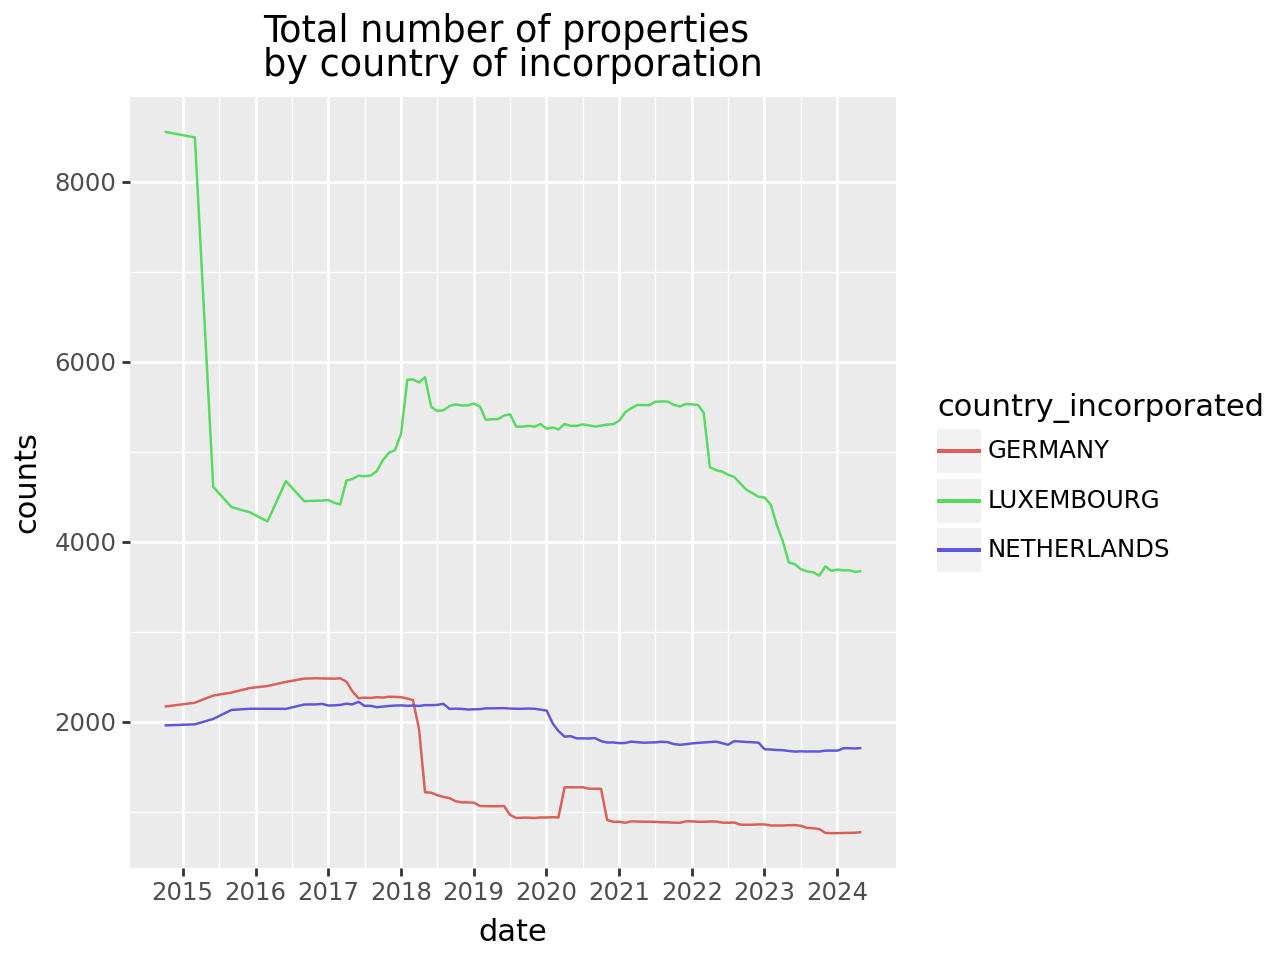

In [16]:
p = ggplot(test[test['country_incorporated'].isin(['LUXEMBOURG', 'NETHERLANDS', 'GERMANY'])], aes(x = 'date', 
y = 'counts', 
color = 'country_incorporated') )+ geom_line() + labs(
    title = "Total number of properties\nby country of incorporation",
    ) +   scale_x_date(
     breaks=pd.date_range(start=test['date'].min(), end=test['date'].max(), freq='Y'),
     date_labels='%Y'  # Format to show only year
 ) 

p

In [17]:
df_sorted_all = total_resi_lad_df.groupby(['lad11cd', 'date'])['counts'].sum().reset_index()
df_sorted_all = df_sorted_all.sort_values(['lad11cd', 'date'])
df_sorted_all['counts_diff'] = df_sorted_all.groupby(['lad11cd'])['counts'].diff()
df_sorted_all['is_multi'] = 'all'


df_sorted = total_resi_lad_df.sort_values(['lad11cd', 'date'])

# Calculate the difference in counts between consecutive dates for each LAD11cd
df_sorted['counts_diff'] = df_sorted.groupby(['lad11cd','is_multi'])['counts'].diff()


df_sorted['is_multi'] = np.where(df_sorted['is_multi'], 'multi', 'single')

df_sorted = pd.concat([df_sorted, df_sorted_all], ignore_index = True)

df_diff_change = df_sorted.groupby(['is_multi', 'lad11cd' ])['counts_diff'].mean().reset_index()
df_diff_change['total_mean_change'] = df_diff_change['counts_diff'] * total_resi_lad_df['date'].nunique()

df_diff_change.sort_values('total_mean_change')

,is_multi,lad11cd,counts_diff,total_mean_change
44,all,E06000047,-46.591837,-4612.591837
362,multi,E06000047,-44.224490,-4378.224490
926,single,E09000033,-35.357143,-3500.357143
295,all,E09000033,-32.081633,-3176.081633
249,all,E08000024,-24.877551,-2462.877551
...,...,...,...,...
287,all,E09000025,14.204082,1406.204082
229,all,E08000003,16.561224,1639.561224
542,multi,E08000003,17.183673,1701.183673
605,multi,E09000030,75.826531,7506.826531


In [18]:
df_diff_change = df_sorted.groupby(['is_multi', 'lad11cd' ])['counts_diff'].mean().reset_index()
df_diff_change['total_mean_change'] = df_diff_change['counts_diff'] * total_resi_lad_df['date'].nunique()

df_diff_change.sort_values('total_mean_change')

,is_multi,lad11cd,counts_diff,total_mean_change
44,all,E06000047,-46.591837,-4612.591837
362,multi,E06000047,-44.224490,-4378.224490
926,single,E09000033,-35.357143,-3500.357143
295,all,E09000033,-32.081633,-3176.081633
249,all,E08000024,-24.877551,-2462.877551
...,...,...,...,...
287,all,E09000025,14.204082,1406.204082
229,all,E08000003,16.561224,1639.561224
542,multi,E08000003,17.183673,1701.183673
605,multi,E09000030,75.826531,7506.826531


In [24]:
import geopandas as gpd

# Direct WFS URL with correct parameters
wfs_url = "https://dservices1.arcgis.com/ESMARspQHYMw9BZ9/arcgis/services/Local_Authority_Districts_May_2022_UK_BSC_V3/WFSServer?service=WFS&version=2.0.0&request=GetFeature&typeName=Local_Authority_Districts_May_2022_UK_BSC_V3:LAD_MAY_2022_UK_BSC_V3&outputFormat=GEOJSON&srsName=EPSG:4326"

try:
    print("Loading Local Authority Districts data...")
    gdf = gpd.read_file(wfs_url)
    print(f"Successfully loaded {len(gdf)} Local Authority Districts")
    print(f"Columns: {list(gdf.columns)}")
    print(f"CRS: {gdf.crs}")
    
    # Display first few rows
    print("\nFirst 3 rows:")
    print(gdf[[LAD_COLUMN_CODE, LAD_COLUMN_NAME]].head(3))
    
except Exception as e:
    print(f"Error: {e}")

Loading Local Authority Districts data...


Successfully loaded 374 Local Authority Districts
Columns: ['GmlID', 'OBJECTID', 'LAD22CD', 'LAD22NM', 'BNG_E', 'BNG_N', 'LONG', 'LAT', 'GlobalID', 'Shape__Area', 'Shape__Length', 'geometry']
CRS: EPSG:4326

First 3 rows:
     LAD22CD               LAD22NM
0  E06000001            Hartlepool
1  E06000002         Middlesbrough
2  E06000003  Redcar and Cleveland


In [25]:
# Helper function to calculate months between dates
def months_between(date1, date2):
    return (date2.year - date1.year) * 12 + (date2.month - date1.month)

# Process 'all' group
df_sorted_all = total_resi_lad_df.groupby(['lad11cd', 'date'])['counts'].sum().reset_index()
df_sorted_all = df_sorted_all.sort_values(['lad11cd', 'date'])
df_sorted_all['counts_diff'] = df_sorted_all.groupby(['lad11cd'])['counts'].diff()

# Calculate months between consecutive dates
df_sorted_all['prev_date'] = df_sorted_all.groupby(['lad11cd'])['date'].shift(1)
df_sorted_all['months_diff'] = df_sorted_all.apply(
    lambda row: months_between(row['prev_date'], row['date']) if pd.notna(row['prev_date']) else np.nan, 
    axis=1
)

# Calculate monthly change (divide by number of months)
df_sorted_all['monthly_change'] = df_sorted_all['counts_diff'] / df_sorted_all['months_diff']
df_sorted_all['is_multi'] = 'all'

# Process main dataframe
df_sorted = total_resi_lad_df.sort_values(['lad11cd', 'date'])

# Calculate the difference in counts between consecutive dates for each LAD11cd
df_sorted['counts_diff'] = df_sorted.groupby(['lad11cd','is_multi'])['counts'].diff()

# Calculate months between consecutive dates
df_sorted['prev_date'] = df_sorted.groupby(['lad11cd', 'is_multi'])['date'].shift(1)
df_sorted['months_diff'] = df_sorted.apply(
    lambda row: months_between(row['prev_date'], row['date']) if pd.notna(row['prev_date']) else np.nan, 
    axis=1
)

# Calculate monthly change (divide by number of months)
df_sorted['monthly_change'] = df_sorted['counts_diff'] / df_sorted['months_diff']

df_sorted['is_multi'] = np.where(df_sorted['is_multi'], 'multi', 'single')

# Use monthly_change instead of counts_diff for concatenation
df_sorted_all_final = df_sorted_all[['lad11cd', 'date', 'monthly_change', 'is_multi']]
df_sorted_final = df_sorted[['lad11cd', 'date', 'monthly_change', 'is_multi']]

df_sorted_combined = pd.concat([df_sorted_final, df_sorted_all_final], ignore_index=True)

# Calculate mean monthly change
df_diff_change = df_sorted_combined.groupby(['is_multi', 'lad11cd'])['monthly_change'].mean().reset_index()

# Calculate total months in dataset
min_date = total_resi_lad_df['date'].min()
max_date = total_resi_lad_df['date'].max()
total_months = months_between(min_date, max_date)

# Multiply by total months instead of unique dates
df_diff_change['total_mean_change'] = df_diff_change['monthly_change'] * total_months

df_diff_change.sort_values('total_mean_change')

,is_multi,lad11cd,monthly_change,total_mean_change
249,all,E08000024,-25.588776,-2942.709184
926,single,E09000033,-23.767007,-2733.205782
562,multi,E08000024,-23.108503,-2657.477891
248,all,E08000023,-22.401361,-2576.156463
295,all,E09000033,-22.253741,-2559.180272
...,...,...,...,...
287,all,E09000025,13.189456,1516.787415
229,all,E08000003,16.928912,1946.824830
542,multi,E08000003,17.194898,1977.413265
605,multi,E09000030,75.052381,8631.023810


In [26]:
temp = df_diff_change.copy()

temp['increase'] = (temp['total_mean_change']>0).astype(int)

temp.groupby('is_multi')['increase'].describe()

,count,mean,std,min,25%,50%,75%,max
is_multi,,,,,,,,
all,318.0,0.515723,0.500540,0.0,0.0,1.0,1.0,1.0
multi,313.0,0.594249,0.491823,0.0,0.0,1.0,1.0,1.0
single,318.0,0.242138,0.429053,0.0,0.0,0.0,0.0,1.0


/tmp/ipykernel_447644/2947365823.py:48: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/tmp/ipykernel_447644/2947365823.py:49: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/tmp/ipykernel_447644/2947365823.py:48: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/tmp/ipykernel_447644/2947365823.py:49: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



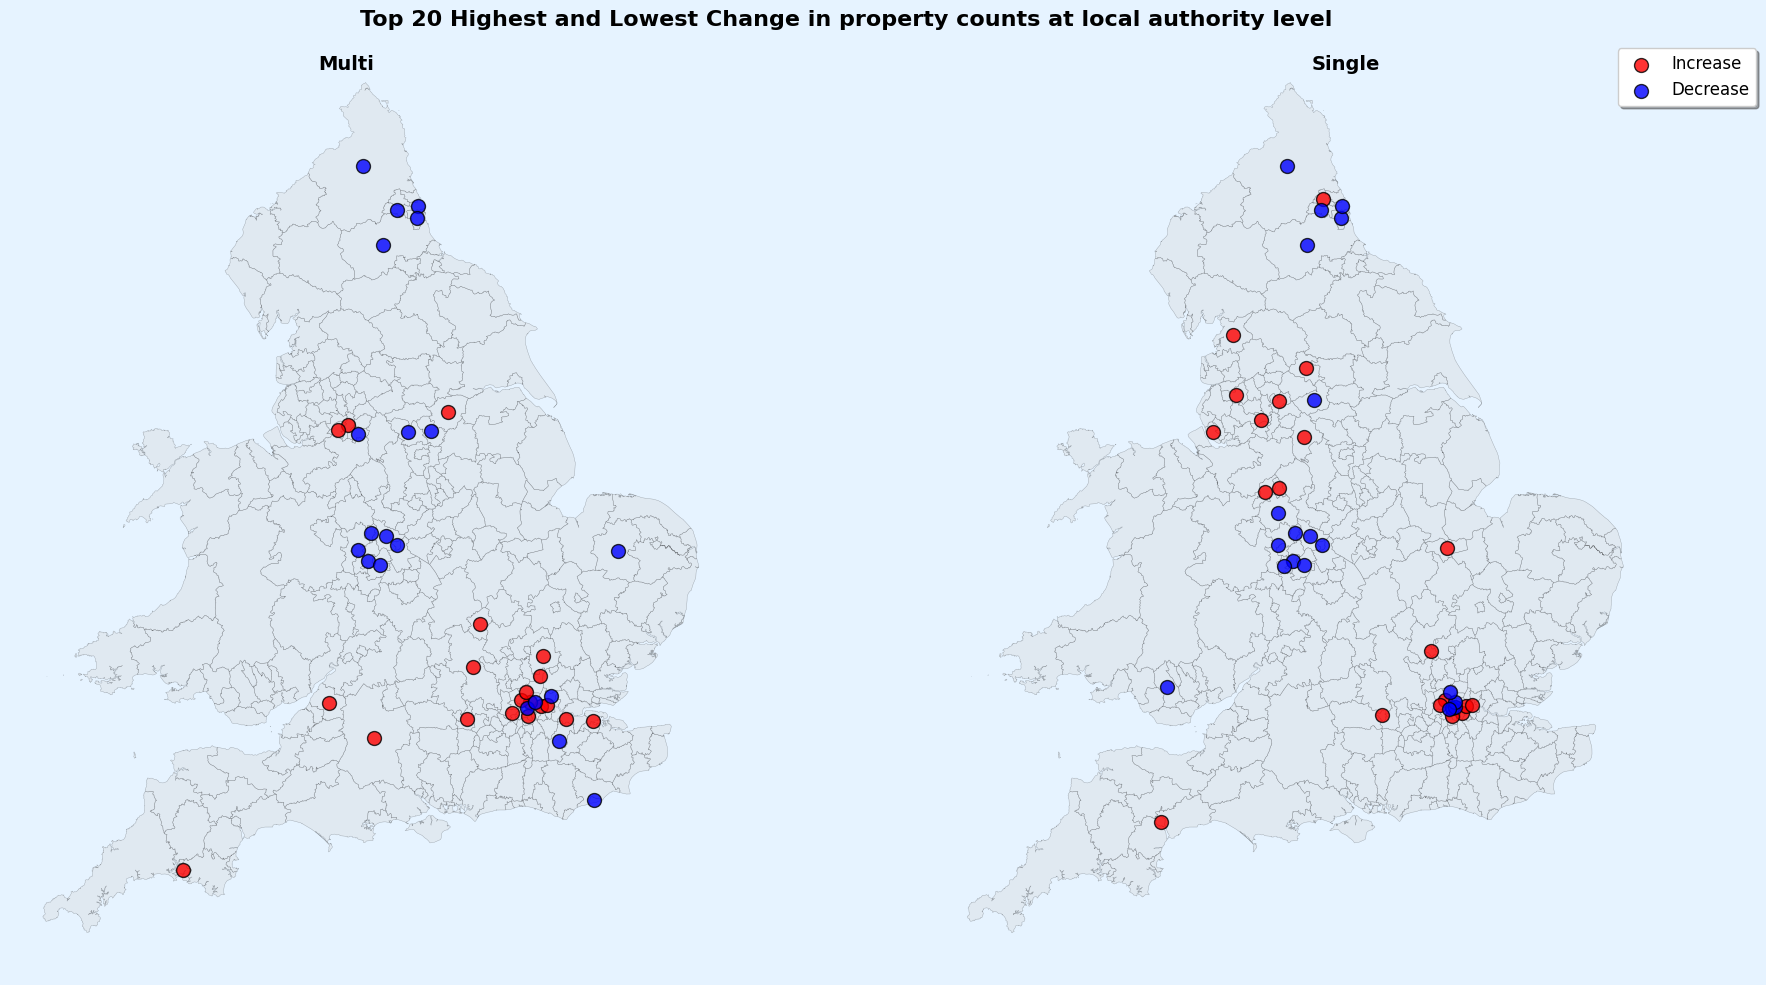

In [27]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

# Filter gdf to only include areas with LAD23CD containing "E" or "W" Remove silly isles for visual compactness
gdf_filtered = gdf[gdf[LAD_COLUMN_CODE].str.contains('E|W', na=False) & (gdf[LAD_COLUMN_CODE]!='E06000053')]

# Create subplots with light blue background
fig, axes = plt.subplots(1, 2, figsize=(20, 10), facecolor='#E6F3FF')

# Categories to plot
categories = ['multi', 'single']

# Plot each category
for i, category in enumerate(categories):
    # Merge for each category
    gdf_temp = gdf_filtered.merge(df_diff_change.loc[df_diff_change['is_multi']==category], 
                                  left_on=LAD_COLUMN_CODE, 
                                  right_on='lad11cd', 
                                  how='left')
    
    # Fill missing values with 0
    gdf_temp['total_mean_change'] = gdf_temp['total_mean_change'].fillna(0)
    
    # Apply transformation
    gdf_temp['total_mean_change'] = np.where(gdf_temp['total_mean_change'] < -500, -500, gdf_temp['total_mean_change'])
    
    # Set light blue background for axes
    axes[i].set_facecolor('#E6F3FF')
    
    # Plot base map with light gray fill and black borders
    gdf_filtered.plot(ax=axes[i], 
                      facecolor='lightgray', 
                      edgecolor='black', 
                      linewidth=0.3,
                      alpha=0.3)
    
    # Remove rows with NaN values for ranking
    gdf_temp_clean = gdf_temp.dropna(subset=['total_mean_change'])
    
    # Get top 10 highest values
    top_10_highest = gdf_temp_clean.nlargest(20, 'total_mean_change')
    
    # Get top 10 lowest values  
    top_10_lowest = gdf_temp_clean.nsmallest(20, 'total_mean_change')
    
    # Get centroids for point plotting
    top_10_highest_centroids = top_10_highest.geometry.centroid
    top_10_lowest_centroids = top_10_lowest.geometry.centroid
    
    # Plot highest values as red circles
    axes[i].scatter(top_10_highest_centroids.x, 
                    top_10_highest_centroids.y,
                    c='red', 
                    s=100, 
                    alpha=0.8,
                    edgecolor='black',
                    linewidth=1,
                    label='Increase',
                    zorder=5)
    
    # Plot lowest values as blue circles
    axes[i].scatter(top_10_lowest_centroids.x, 
                    top_10_lowest_centroids.y,
                    c='blue', 
                    s=100, 
                    alpha=0.8,
                    edgecolor='black',
                    linewidth=1,
                    label='Decrease',
                    zorder=5)
    
    # Add legend only to the second plot
    if i == 1:
        axes[i].legend(loc='upper right', 
                      bbox_to_anchor=(1.15, 1),
                      fontsize=12,
                      frameon=True,
                      fancybox=True,
                      shadow=True)
    
    # Turn off axis
    axes[i].set_axis_off()

# Add titles manually using fig.text for perfect alignment
fig.text(0.25, 0.92, 'Multi', fontsize=14, fontweight='bold', ha='center')
fig.text(0.75, 0.92, 'Single', fontsize=14, fontweight='bold', ha='center')

# Overall title
fig.suptitle('Top 20 Highest and Lowest Change in property counts at local authority level', 
             fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()
plt.savefig(figures_folder /'change_maps.png')
plt.show()




In [28]:
gdf_filtered.merge(df_diff_change.loc[df_diff_change['is_multi']=='multi'], 
                                  left_on=LAD_COLUMN_CODE, 
                                  right_on='lad11cd', 
                                  how='left')['total_mean_change'].describe()

count     309.000000
mean       40.741178
std       586.044832
min     -2657.477891
25%       -12.140081
50%        11.656463
75%        71.894558
max      8631.023810
Name: total_mean_change, dtype: float64

In [29]:
temp = gdf_filtered.merge(df_diff_change.loc[df_diff_change['is_multi']=='all'], 
                                  left_on=LAD_COLUMN_CODE, 
                                  right_on='lad11cd', 
                                  how='left').sort_values('total_mean_change')

temp.loc[temp['total_mean_change'].notna(), ["LAD22NM", "total_mean_change"]].head(10)

,LAD22NM,total_mean_change
261,Sunderland,-2942.709184
260,South Tyneside,-2576.156463
307,Westminster,-2559.180272
44,County Durham,-2346.352041
294,Kensington and Chelsea,-1982.420068
257,Sheffield,-1849.153061
194,Lichfield,-1083.151361
274,Gateshead,-828.625850
52,Northumberland,-789.940476
192,Cannock Chase,-741.671769


# concentration

As we can see the majority of change is concentrated into a very small number of local authorities. The below shows the fraction the 20 LADS with the biggest increases make up of the total increase, and the 20 with the biggest decrease make up of all decreases

In [43]:
temp.loc[temp['total_mean_change'].notna() & (temp['total_mean_change']<0), ["LAD22NM", "total_mean_change"]].head(20)['total_mean_change'].sum()/ \
    temp.loc[temp['total_mean_change'].notna() & (temp['total_mean_change']<0),'total_mean_change'].sum()

0.7872957117926428

In [31]:
temp.loc[temp['total_mean_change'].notna() & (temp['total_mean_change']>0), ["LAD22NM", "total_mean_change"]].tail(20)['total_mean_change'].sum()/ \
    temp.loc[temp['total_mean_change'].notna() & (temp['total_mean_change']>0),'total_mean_change'].sum()

0.6783301293156442

In [40]:
lad_price_df = create_mean_difference_by_groups( ['lad11cd', 'is_multi'], 
ocod_path = OCOD_history_path, 
class_var = active_class_var)


100%|██████████| 99/99 [00:49<00:00,  2.00it/s]


In [41]:
lad_price_all_df = create_mean_difference_by_groups( ['lad11cd'], ocod_path = OCOD_history_path,
class_var = active_class_var)

100%|██████████| 99/99 [00:45<00:00,  2.19it/s]


In [46]:
lad_price_df.groupby(['ratio_significantly_different', 'is_multi']).size()

ratio_significantly_different  is_multi
False                          False        20
                               True         37
True                           False       298
                               True        276
dtype: int64

In [47]:
lad_price_df.pivot(columns = 'is_multi', 
index = 'lad11cd', 
values = 'mean_weighted_difference').rename(columns ={False:"single_price", True:"nested_price"})

is_multi,single_price,nested_price
lad11cd,,
E06000001,386.288630,760.179990
E06000002,89.579737,747.736190
E06000003,486.043574,242.233398
E06000004,114.398464,-169.219043
E06000005,161.283953,1574.935008
...,...,...
W06000020,1046.490617,707.146350
W06000021,1600.656229,1112.657482
W06000022,824.718570,773.800434


In [48]:
lad_price_all_df.rename(columns = {'mean_weighted_difference':'all_offshore_change', 'mean_unweighted_difference':'general_property_change'})

,all_offshore_change,general_property_change,mean_price_ratio,ratio_fraction_above_one,ratio_fraction_below_one,ratio_significantly_different,ratio_ci_lower,ratio_ci_upper,n_periods,n_ratio_observations,lad11cd
0,560.585876,234.940006,0.993090,0.141,0.859,False,0.981398,1.006111,98,99,E06000001
1,480.162277,189.721862,1.048348,1.000,0.000,True,1.034551,1.064625,98,99,E06000002
2,344.195512,484.316243,0.888637,0.000,1.000,True,0.884280,0.893248,98,99,E06000003
3,-102.105395,442.610123,0.858299,0.000,1.000,True,0.844865,0.871791,98,99,E06000004
4,1077.548063,402.088670,1.272009,1.000,0.000,True,1.256426,1.286971,98,99,E06000005
...,...,...,...,...,...,...,...,...,...,...,...
313,1187.858303,1533.458523,1.014174,0.995,0.005,True,1.004167,1.026123,98,99,W06000020
314,1493.333829,1557.810634,0.949869,0.000,1.000,True,0.947151,0.952985,98,99,W06000021
315,809.985566,786.238076,0.941207,0.000,1.000,True,0.938310,0.944204,98,99,W06000022
316,895.393046,747.134206,1.037753,1.000,0.000,True,1.031461,1.043385,98,99,W06000023


In [49]:
price_change_data = lad_price_df.pivot(columns = 'is_multi', 
index = 'lad11cd', 
values = 'mean_weighted_difference').rename(columns ={False:"single_price", True:"nested_price"})

price_change_data_all = lad_price_all_df.rename(columns = {'mean_weighted_difference':'all_offshore_change', 'mean_unweighted_difference':'general_property_change'})
price_change_data_all['price_ratio'] = price_change_data_all['all_offshore_change']/price_change_data_all['general_property_change']

volume_change_data = df_diff_change.loc[:, ['is_multi','lad11cd', 'total_mean_change']].pivot(
    columns = 'is_multi', index ='lad11cd', values = 'total_mean_change')

full_data_compare = price_change_data.merge(volume_change_data, on = 'lad11cd').merge(
price_change_data_all, on = 'lad11cd'
).fillna(0)

conditions = [
    full_data_compare['price_ratio'] > 1.05,
    full_data_compare['price_ratio'] < 0.95
]
choices = ['increase', 'decrease']

# Create categorical column
full_data_compare['price_change'] = np.select(conditions, choices, default='stable')

conditions = [
    full_data_compare['all'] > 10,
    full_data_compare['all'] < -10
]
choices = ['increase', 'decrease']

# Create categorical column
full_data_compare['volume_change'] = np.select(conditions, choices, default='stable')

In [50]:
(full_data_compare[['all', 'price_ratio']]).describe()

,all,price_ratio
count,318.000000,318.000000
mean,3.157543,0.959947
std,637.308299,0.288261
min,-2942.709184,-0.230689
25%,-38.225765,0.801291
50%,1.799320,0.951634
75%,52.092262,1.084935
max,8864.505102,2.679877


In [51]:
# Create crosstab with better labels
crosstab = pd.crosstab(
    full_data_compare['price_change'] ,
    full_data_compare['volume_change'] ,
    rownames=['volume increase'],
    colnames=['relative_price increase'],
    margins=False,
    normalize = False
)
print(crosstab)

relative_price increase  decrease  increase  stable
volume increase                                    
decrease                       56        83      19
increase                       45        35      18
stable                         24        25      13


In [52]:
# Create crosstab with better labels
crosstab = pd.crosstab(
    full_data_compare['price_change'] ,
    full_data_compare['volume_change'] ,
    rownames=['volume increase'],
    colnames=['relative_price increase'],
    margins=False,
    normalize = True
)
print(crosstab)

relative_price increase  decrease  increase    stable
volume increase                                      
decrease                 0.176101  0.261006  0.059748
increase                 0.141509  0.110063  0.056604
stable                   0.075472  0.078616  0.040881


#  model analayis

In [60]:
import pandas as pd
import glob
from pathlib import Path
import numpy as np

# Find all 'overall' CSVs in the model_performance directory
performance_dir = Path("../data/model_performance")
overall_files = list(performance_dir.glob("*overall*.csv"))

# Load and concatenate all relevant CSVs
dfs = []
for file in overall_files:
    df = pd.read_csv(file)
    df['source_file'] = file.name  # Optionally add a column to indicate the source
    dfs.append(df)


combined = pd.concat(dfs, ignore_index=True)[['precision', 'recall', 'f1_score', 'source_file']]
combined['prepocessed'] = combined['source_file'].str.contains('preprocessed')
combined[['precision', 'recall', 'f1_score',]] = combined[['precision', 'recall', 'f1_score',]].round(2)
combined['model_type'] = np.where(
    combined['source_file'].str.contains('devset'), 
    'conventional', 
    np.where(
        combined['source_file'].str.contains('regex'), 
        'regex', 
        'weak-learning'
    )
)
combined = combined[['model_type',  'prepocessed', 'f1_score','precision', 'recall']].sort_values('model_type')
combined.rename(columns={'f1_score': 'F1', 'model_type': 'Model Type',
 'prepocessed': 'Preprocessed', 'precision': 'Precision', 'recall': 'Recall'}, inplace=True)
# Print the LaTeX table
latex_table = combined.to_latex(
    index=False, 
    float_format='{:.2f}'.format,
    caption='Performance Comparison of Different Model Configurations',
    label='tab:model_performance',
    position='htbp',
    escape=False
)

table_file = figures_folder / 'model_performance_table.tex'
with open(table_file, 'w') as f:
    f.write(latex_table)

print(latex_table)


\begin{table}[htbp]
\caption{Performance Comparison of Different Model Configurations}
\label{tab:model_performance}
\begin{tabular}{lrrrr}
\toprule
Model Type & Preprocessed & F1 & Precision & Recall \\
\midrule
conventional & False & 0.95 & 0.95 & 0.96 \\
conventional & True & 0.94 & 0.93 & 0.95 \\
weak-learning & False & 0.92 & 0.95 & 0.89 \\
weak-learning & True & 0.92 & 0.95 & 0.89 \\
\bottomrule
\end{tabular}
\end{table}



In [57]:


class_table = pd.read_csv('../data/model_performance/test_original_fullset_class_performance.csv')
class_table = class_table[['class_name', 'precision', 'recall', 'f1_score', 'support']]
class_table.rename(columns={'f1_score': 'F1', 'precision': 'Precision', 'recall': 'Recall', 'class_name': active_class_var }, inplace=True)
class_table[active_class_var] = class_table[active_class_var].str.replace("_", " ")

In [58]:
class_table

,class,Precision,Recall,F1,support
0,building name,0.823245,0.887728,0.854271,383
1,city,0.976720,0.974657,0.975687,947
2,number filter,1.000000,1.000000,1.000000,23
3,postcode,1.000000,1.000000,1.000000,768
4,street name,0.976091,0.912536,0.943245,1029
5,street number,0.903967,0.638643,0.748487,678
6,unit id,0.974684,0.832432,0.897959,370
7,unit type,0.908549,0.936475,0.922301,488
8,micro avg,0.950556,0.894366,0.921605,4686
9,macro avg,0.945407,0.897809,0.917744,4686


In [61]:

latex_table = class_table.to_latex(
    index=False, 
    float_format='{:.2f}'.format,
    caption='Performance is high across all classes indicating a well trained, reliable model',
    label='tab:class_performance',
    position='htbp',
    escape=False
)


table_file = figures_folder / 'class_performance_table.tex'
with open(table_file, 'w') as f:
    f.write(latex_table)

print(latex_table)



\begin{table}[htbp]
\caption{Performance is high across all classes indicating a well trained, reliable model}
\label{tab:class_performance}
\begin{tabular}{lrrrr}
\toprule
class & Precision & Recall & F1 & support \\
\midrule
building name & 0.82 & 0.89 & 0.85 & 383 \\
city & 0.98 & 0.97 & 0.98 & 947 \\
number filter & 1.00 & 1.00 & 1.00 & 23 \\
postcode & 1.00 & 1.00 & 1.00 & 768 \\
street name & 0.98 & 0.91 & 0.94 & 1029 \\
street number & 0.90 & 0.64 & 0.75 & 678 \\
unit id & 0.97 & 0.83 & 0.90 & 370 \\
unit type & 0.91 & 0.94 & 0.92 & 488 \\
micro avg & 0.95 & 0.89 & 0.92 & 4686 \\
macro avg & 0.95 & 0.90 & 0.92 & 4686 \\
weighted avg & 0.95 & 0.89 & 0.92 & 4686 \\
\bottomrule
\end{tabular}
\end{table}

